# Scalable Gaussian Process Deep Learning
*MADSTARE LDRD machine learning tutorials*

In this tutorial we will expand upon the use of the Gaussian Process (GP) analog to wide, deep neural networks. We will use the MNIST hand-written digits data set as the example for study and compare with the performance of a neural network from the [TensorFlow library tutorial example for MNIST](https://www.tensorflow.org/tutorials), as well as an implementation of Lee, Bahri et al.'s neural network Gaussian process (nngp) [Deep Neural Networks as Gaussian Processes](https://arxiv.org/abs/1711.00165).

## Deep Neural Networks


# MNIST Image Classification
As discussed previously, MNIST is a normalized set $\left \{x_i \right \}_{i = 1}^N$ of $N$ $d = 28 * 28 = 784$ pixel images, each associated with a single-digit numeral. We want an system that can automatically assign the correct numeral label to a previously-unseen image. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gpnn

from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style(context='notebook', fscale=1.5, figsize=(8.0, 8.0/1.618))

We will load the MNIST dataset and display some images.

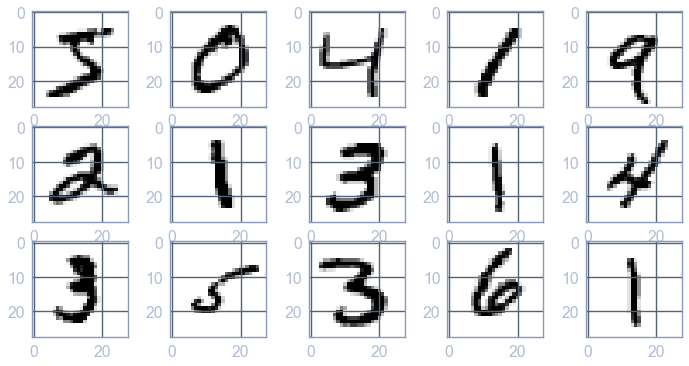

In [3]:
import tensorflow as tf
mnist_keras = tf.keras.datasets.mnist
(x_train_full, y_train_full),(x_test_full, y_test_full) = mnist_keras.load_data()
x_train_full, x_test_full = x_train_full / 255.0, x_test_full / 255.0

im_nx, im_ny = x_train_full.shape[1:3]

fig = plt.figure(figsize=(12,6))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(x_train_full[i,:,:], cmap=plt.cm.gray_r)

## Neural Network Gaussian Process
We will classify MNIST using an NNGP. 

In [4]:
def convert_to_one_hot(a, num_labels=10):
    b = np.zeros((a.shape[0], num_labels))
    b[np.arange(a.shape[0]), a] = 1
    return b

def get_gp_data_subset(n_train=500, n_test=500):
    x_flat = np.row_stack((x_train_full[0:n_train, ...].reshape((n_train, im_nx*im_ny)),
                           x_test_full[0:n_test, ...].reshape(n_test, im_nx*im_ny)))
    return x_flat

In [5]:
n_train = 500
n_test = 500

We prepare the image data for regression by stacking the flattened images and normalizing each row of the data array to have constant variance.

In [6]:
x_gp = get_gp_data_subset()
x = gpnn.util.normalize(x_gp)

We use a one-hot encoding, adjusted according to recent conventions to have zero mean. Accordingly, a label of e.g. 3 is converted to the 10-vector $e_3 - 0.1 \mathbb{1} = [0, 0, 0, 3, 0, 0, 0, 0, 0, 0]^T$.

In [7]:
labels_train = convert_to_one_hot(y_train_full[0:n_train]) - 0.1
labels_test = convert_to_one_hot(y_test_full[0:n_test]) - 0.1

### Kernel construction

Now it's time to construct the GP kernel. 

The kernel has two parameters corresponding to the variances in the zero-mean Gaussian priors on the neural net node weights ($\sigma_w^2$) and biases ($\sigma_b^2$). We'll adopt the values learned from the grid search in predictive performance accuracy from the Google Brain paper in 2017. 

In [7]:
sigma_w_sq = 1.79
sigma_b_sq = 0.83

The kernel also requires specification of the number 'layers'. This is the number of iterations in the recursive composition of the kernel, which mimics the layers in a deep fully-connected feed forward network. We'll choose 100 layers to match the first entry in Table 2 of the Google Brain paper.

In [8]:
L = 100

Now, we build the kernel gram matrix for the selected training and test data using the analytic form for the ReLu activation.

(This can take a couple of minutes to run.)


In [9]:
%time Ka = gpnn.kern_analytic(x, sigma_b_sq, sigma_w_sq, L=L)

CPU times: user 5.44 s, sys: 387 ms, total: 5.83 s
Wall time: 5.21 s


Instead, we can look at the kernel values as a function of the 'angle' between input data points, which is defined by the dot product of the 282 length image vectors.

Text(0, 0.5, 'Kernel value')

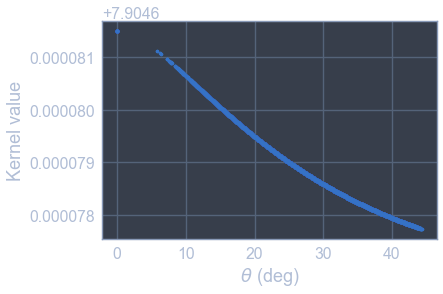

In [10]:
cos_theta = np.dot(x, x.transpose()) / x.shape[1]
np.fill_diagonal(cos_theta, 1.0)
theta_deg = np.arccos(cos_theta).ravel()*180/(2*np.pi) 
plt.plot(theta_deg, Ka.ravel(), '.')
plt.xlabel(r"$\theta$ (deg)")
plt.ylabel("Kernel value")

This shows that even after the 100 recursive compositions of the kernel and the modeling of the nonlinear ReLU activation, we still end up with kernel values that are a smooth function of the angles between input images.

It's also perhaps interesting to think about the span of angles we see in the data - from ~5 degrees to ~45 degrees.

Let's look at how the shape of $K(\theta)$ changes with increasing number of layers.

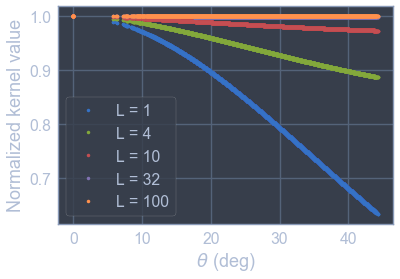

In [11]:
num_layers = np.ceil(np.logspace(0, 2, 5))
for nL in num_layers:
    Ka = gpnn.kern_analytic(x, sigma_b_sq, sigma_w_sq, L=int(nL))
    plt.plot(np.arccos(cos_theta).ravel()*180/(2*np.pi), Ka.ravel() / np.max(Ka), '.',
             label=r"L = {:d}".format(int(nL)))
plt.xlabel(r"$\theta$ (deg)")
plt.ylabel("Normalized kernel value")
plt.legend()

### Label prediction for test data


We predict the labels for the test data by computing the GP posterior mean and covariance conditioning on the training data.

We need to specify a measurement 'noise' for the regression problem. For now, we treat this as an asserted parameter that can be optimized later.

In [12]:
noise_var = 1e-8

In [13]:
post_mean, post_cov = gpnn.predict(Ka, labels_train, n_train, n_test, epsvar=noise_var)

In [14]:
print("Test accuracy: {:5.4f}".format(np.sum(np.equal(np.argmax(post_mean, 1), 
                                                      np.argmax(labels_test, 1))
                                            ) / float(n_test)))

Test accuracy: 0.8900


## Computation time versus neural network in tensorflow
https://www.tensorflow.org/tutorials/

In [15]:
x_train = x_train_full[0:n_train, ...]
y_train = y_train_full[0:n_train]
x_test = x_test_full[0:n_test, ...]
y_test = y_test_full[0:n_test]

In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

%time model.fit(x_train, y_train, epochs=5)
%time model.evaluate(x_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5
500/500 [==============================] - 0s 433us/sample - loss: 1.5012 - acc: 0.5740
Epoch 2/5
500/500 [==============================] - 0s 171us/sample - loss: 0.5479 - acc: 0.8700
Epoch 3/5
500/500 [==============================] - 0s 174us/sample - loss: 0.3238 - acc: 0.9140
Epoch 4/5
500/500 [==============================] - 0s 189us/sample - loss: 0.2184 - acc: 0.9440
Epoch 5/5
500/500 [==============================] - 0s 181us/sample - loss: 0.1486 - acc: 0.9780
CPU times: user 2.13 s, sys: 357 ms, total: 2.49 s
Wall time: 925 ms
500/500 [==============================] - 0s 166us/sample - loss: 0.4974 - acc: 0.8440
CPU times: user 121 ms, sys: 9.59 ms, total: 131 ms
Wall time: 98.5 ms


[0.4973974857330322, 0.844]

In [17]:
L = 10
def gpnn_compute(n_train, n_test):
    x_gp = get_gp_data_subset(n_train=n_train, n_test=n_test)
    x = gpnn.util.normalize(x_gp)
    labels_train = convert_to_one_hot(y_train_full[0:n_train]) - 0.1
#     labels_test = convert_to_one_hot(y_test_full[0:n_test]) - 0.1
    Ka = gpnn.kern_analytic(x, sigma_b_sq, sigma_w_sq, L=L)
    post_mean, post_cov = gpnn.predict(Ka, labels_train, n_train, n_test)
    
def nn_compute(n_train, n_test):
    x_train = x_train_full[0:n_train, ...]
    y_train = y_train_full[0:n_train]
    x_test = x_test_full[0:n_test, ...]
    y_test = y_test_full[0:n_test]  
    model.fit(x_train, y_train, epochs=5, verbose=False)
    model.evaluate(x_test, y_test)

n_data = [100, 200, 300, 500, 700, 1000, 2000]
t_nn = []; t_gp = []
for n in n_data:
    t1 = %timeit -o -r 1 -n 1 nn_compute(n, n)
    t2 = %timeit -o -r 1 -n 1 gpnn_compute(n, n)
    t_nn.append(t1.average)
    t_gp.append(t2.average)

100/100 [==============================] - 0s 55us/sample - loss: 0.4871 - acc: 0.8200
92.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
35.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
200/200 [==============================] - 0s 42us/sample - loss: 0.4185 - acc: 0.8200
154 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
98.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
300/300 [==============================] - 0s 38us/sample - loss: 0.4506 - acc: 0.8333
208 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
197 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
500/500 [==============================] - 0s 46us/sample - loss: 0.4558 - acc: 0.8520
350 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
603 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
700/700 [==============================] - 0s 39us/sample - loss: 0.4681 - acc: 0.8671
469 ms ± 0 ns per loop (mean ± std. dev. of 1 run,

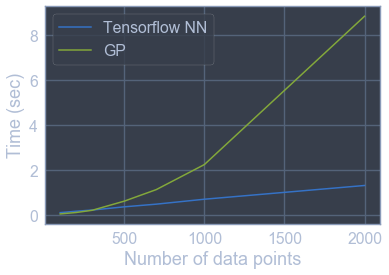

In [18]:
plt.plot(n_data, t_nn, label="Tensorflow NN")
plt.plot(n_data, t_gp, label="GP")
plt.xlabel("Number of data points")
plt.ylabel("Time (sec)")
plt.legend()

We have found that the NNGP yields comparable or even better results than an instantiated neural network. However, the NNGP exhibits much worse scaling due to the $O(n^3)$ term in the regression. Moreover, the authors of the Google Brain paper and others acknowledge that the recursive neural network kernel is itself expensive to compute. 

We will attempt to ameliorate these problems via an alternative GP model known as the "Nearest Neighbor GP." We will avoid referring to it as the NNGP.

# The N4GP: Quality and Speed analysis

In [8]:
import pyNNGP
import ipywidgets as widgets

from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize

In [20]:
x_gp = get_gp_data_subset(n_train=500, n_test=500)

In [9]:
def n4gp_compute(n_train, n_test, L=30, sigmaSqW=1.84, sigmaSqB=0.04, noise=0.01, nNeighbors=10):
    x_gp = get_gp_data_subset(n_train=n_train, n_test=n_test)
    x_train = x[0:n_train]
    x_test = x[n_train:]
    labels_train = convert_to_one_hot(y_train_full[0:n_train]) - 0.1
    labels_test = convert_to_one_hot(y_test_full[0:n_test]) - 0.1
    
    covModel = pyNNGP.NNKernel(
        L=L, sigmaSqW=sigmaSqW, sigmaSqB=sigmaSqB
    )
    
    noiseModel = pyNNGP.ConstHomogeneousNoiseModel(noise)

    distFunc = pyNNGP.DotProduct()

    # fit the model
    n4gp = pyNNGP.SeqNNGP(
        labels_train, x_train,
        nNeighbors=nNeighbors,
        covModel=covModel,
        distFunc=distFunc,
        noiseModel=noiseModel,
        normalize=True
    )
#     labels_test = convert_to_one_hot(y_test_full[0:n_test]) - 0.1
    post_mean = n4gp.MAPPredict(x_test)
    return post_mean

In [1]:
post_mean = n4gp_compute(500, 500)

NameError: name 'n4gp_compute' is not defined

In [ ]:
w_samples = []
for i in range(30):
    nngp.sample(10)
    w_samples.append(np.copy(nngp.w))